# Creating Customer Segments

**Project Status: In Progress (Updated: 3/14/2016)

This project will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

In [4]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, FastICA
from sklearn import preprocessing

%matplotlib inline

In [5]:
# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)

print "\nStandard Deviation:"
print data.std()

Dataset has 440 rows, 6 columns

Standard Deviation:
Fresh               12647.328865
Milk                 7380.377175
Grocery              9503.162829
Frozen               4854.673333
Detergents_Paper     4767.854448
Delicatessen         2820.105937
dtype: float64


In [6]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


**1)** Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

- The original dataset is plotted in a high dimensional space (D=5) and is represented in terms of Fresh, Milk, Grocery, etc; transforming the data into the new dimensions which is represented now by the PC's. The first PC accounts or the highest portion of the total variance or "spread" of the data. The following PC's account for the remaining variability, and usually the first couple of PC's account for roughly 90-95% of the variance. We would expect the first several PCs to be composed of original attributes that are in some way correlated with each other. These principal components could represent the customers that purchase certain items or a combination of the items. Additionally, before running any PCA, plotting the histograms (shown below) seems to indicate a correlation in the number of orders among `Fresh`, `Milk`, and `Grocery`. Intuitively, the histograms show an exponential decline in the number of orders for the respected products, hence this could represent a cluster of the larger companies. In contrast to the remaining products, the histogram virtually drops off after the first two bins (lower number of orders) and perhaps indicate the smaller company purchases from the wholesale grocery distributor. In addition to `Fresh` and `Milk` having the highest standard deviations of 12,647 and 9,503 respectively, I would expect these two type of products to be the top two PCs. 


- In short, ICA produces dimensions of variation where the dimensions (features) are as statistically independent from one another. In the context of this project we are attempting to identify the different buyer types and cluster them together. Being statistically independent, the different type of buyer typers could mean the size of the purchaser (small/larger) or different consumption patterns. For example, there are buyers who mostly purchased Milk and Grocery, and less Detergents/Paper or Delicatessen. Likely this could represent the type of purchasers for a small market or convenience store. 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a78bfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10a814050>]], dtype=object)

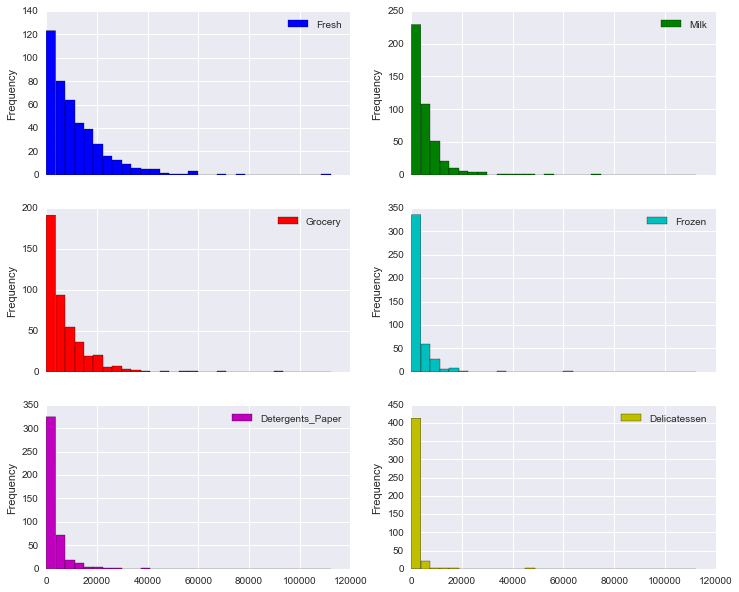

In [7]:
data.plot(kind='hist',bins = 30, subplots=True, layout=(3,2), legend=True, figsize=(12,10))

In [8]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [9]:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


In [10]:
data.cov()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.599549e+08,9381788.549353,-1424712.795724,21236654.585266,-6147825.712088,8727309.970320
Milk,9.381789e+06,54469967.238926,51083186.306513,4442612.093342,23288343.481316,8457924.797624
Grocery,-1.424713e+06,51083186.306513,90310103.754380,-1854281.919549,41895189.687544,5507291.270625
Frozen,2.123665e+07,4442612.093342,-1854281.919549,23567853.166183,-3044324.907072,5352341.761079
Detergents_Paper,-6.147826e+06,23288343.481316,41895189.687544,-3044324.907072,22732436.036400,931680.713238
Delicatessen,8.727310e+06,8457924.797624,5507291.270625,5352341.761079,931680.713238,7952997.497986


###PCA

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

- The figure below shows the result of transforming the dataset with 5 numeric attributes, corresponding to data points in a high dimensional space (d=6). The plot shows the variance vs the component (n=5). Based on the No. Principal Components vs Cumulative Explained Variance Ratio plot (left), the number of dimensions would be reduced to 2, which explains 86.4% of the variance. In this plot, the ['Explained Variance Ratio`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) 
is a fraction of the total variance explained by each of the selected components. In regards to how quickly does the variance drop off, the slope shows that at PC 1-2, the slope is -0.054 and the slope at PC 2-3 is -0.335 (figure on right). The slope at PC 3-4 the slope begins to level out some with a slope of -0.026; therefore between PC 2-3 you observe the steepest slope where the explained variance ratio begins to quickly decline.
 
 
- As a note, for PCA to be implemented correctly, you need to address the event where features are on different scale or different magnitudes of range, and thus causing the results of PCA to be biased in the direction of the features with large range. One approach to scaling the data is using [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html); the features are standardized by removing the mean (centered at zero) and scaling to unit variance. However, it may not always be the case in which the data should be standardized. In some instances you may want to preserve the variance of each dimension as opposed to scaling to unit length, which could remove the potential dependence between features since each feature is scaled independently. The features were not standardized for this dataset as the attributes have the same units monetary units (m.u.) and in essence, we are trying to capture the variance in spending among the different types of customers.

In [11]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
columns = data.columns
mean = data.mean()
df_m = pd.DataFrame(mean)
df_mean = df_m.transpose()
data_center = pd.DataFrame(data[columns].values - df_mean[columns].values, columns=columns)
#print data_center

def doPCA():
    pca = PCA(n_components=5)
    pca.fit(data_center)
    return pca

# Print the components and the amount of variance in the data contained in each dimension
pca = doPCA()
columns = data_center.columns
df_ica = pd.DataFrame(pca.components_, columns = columns, index=['1', '2', '3', '4','5'])
df_ica.index.names = ['PC']
print "Principal Component Analysis:"
print df_ica

ex_var = pca.explained_variance_ratio_
df_var = pd.Series(ex_var,index=['1','2','3','4','5'])
df_var.sort(ascending=False)


df_var.index.names = ['PC']
print "\nExplained Variance of Each Component:"
print df_var

Principal Component Analysis:
       Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
PC                                                                        
1  -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
2  -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
3  -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
4  -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
5   0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077

Explained Variance of Each Component:
PC
1    0.459614
2    0.405172
3    0.070030
4    0.044023
5    0.015022
dtype: float64


/Library/Python/2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


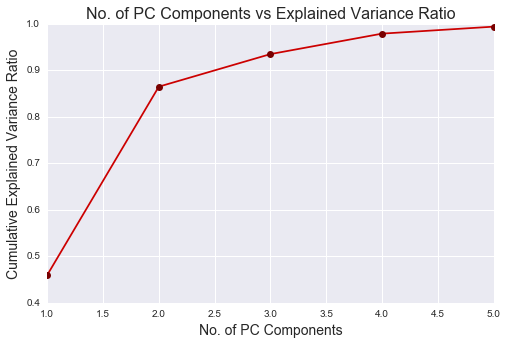

In [12]:
pl.figure(figsize=(8,5))
x = np.arange(1,6)
y = np.cumsum(ex_var)
pl.plot(x,y,marker ="o", mfc='#780000', color = '#CC0000')
pl.xlabel("No. of PC Components", fontsize = 14)
pl.ylabel("Cumulative Explained Variance Ratio", fontsize =14)
pl.title("No. of PC Components vs Explained Variance Ratio", fontsize = 16)
pl.show()

Slope1: -0.054442
Slope2: -0.335142
Slope3: -0.026007


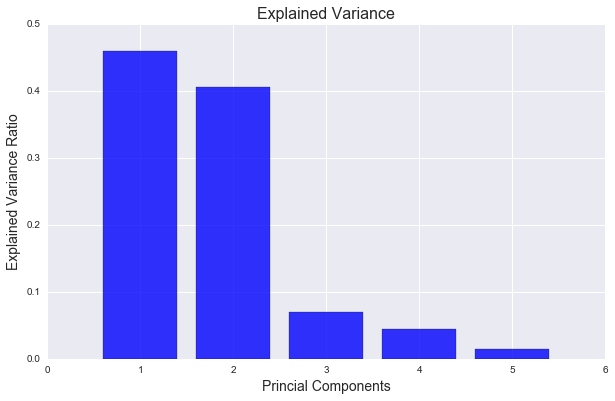

In [13]:
pl.figure(figsize=(10,6))
pl.bar(range(1,6), ex_var, alpha = .8, align='center',
       label = 'Individual Explained Variance', color = 'blue')
pl.ylabel('Explained Variance Ratio', fontsize = 14)
pl.xlabel('Princial Components', fontsize = 14)
pl.title('Explained Variance', fontsize = 16)
pl.show

#Slope:
X1, Y1 = 1, 0.459614
X2, Y2 = 2, 0.405172
X3, Y3 = 3, 0.070030
X4, Y4 = 4, 0.044023
slope1 = (Y2-Y1)/(X2-X1)
slope2 = (Y3-Y2)/(X3-X2)
slope3= (Y4-Y3)/(X4-X3)
print "Slope1:", slope1
print "Slope2:", slope2
print "Slope3:", slope3

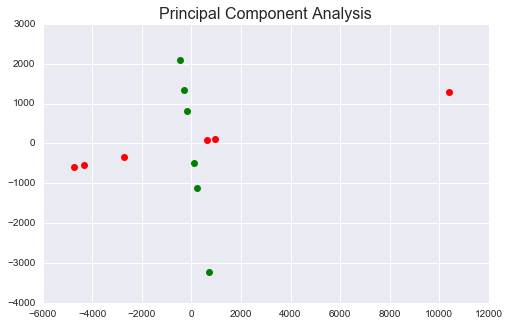

In [14]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]
#print "First PC:", first_pc
#print "Second PC:", second_pc

transformed_data = pca.transform(data_center)
pl.figure(figsize =(8,5))
for ii, jj in zip(transformed_data, data_center):
    pl.plot(first_pc[0]*ii[0], first_pc[1]*ii[0],marker = "o",color="r")
    pl.plot(second_pc[0]*ii[1], second_pc[1]*ii[1],marker ="o",color = "g")
    pl.title("Principal Component Analysis", fontsize = 16)

pl.show()


(-0.3, 1.3)

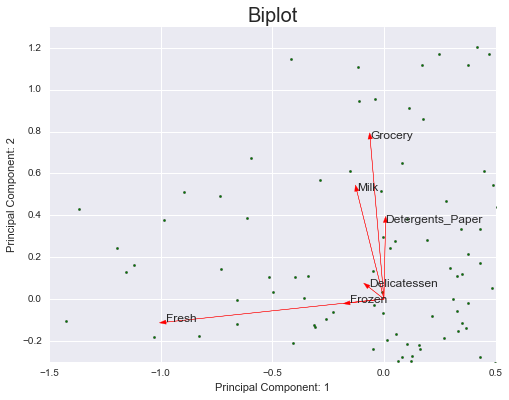

In [15]:
def biplot(df):
    # Fit on 2 components
    pca = PCA(n_components=2, whiten=True).fit(df)
    
    # Plot transformed/projected data
    ax = pd.DataFrame(
        pca.transform(df),
        columns=['PC1', 'PC2']
    ).plot(kind='scatter', x='PC1', y='PC2', figsize=(8, 6), color = 'g', s=5)
    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1, pc2, width=0.001, fc='r', ec='r')
        ax.annotate(df.columns[i], (pc1, pc2), size=12)
    return ax

ax = biplot(data)
pl.title("Biplot", fontsize = 20)
pl.xlabel("Principal Component: 1")
pl.ylabel("Principal Component: 2")
ax.set_xlim([-1.5, .5])
ax.set_ylim([-.3, 1.3])

#### **3)** What do the dimensions seem to represent? How can you use this information? 

- In the original dimensional space the dimensions of the axes are in terms of the amount of monetary units (m.u.) the food distributor sales. The axes are then transposed into the new dimensional space and is now represented by the principal components. First, we must begin by constructing the covariance matrix (S); covariance is the measures how much the features vary from the mean with respect to each other. For this dataset, there are 440 elements (n=440) and 6 measurements (m=6), so the covariance matrix would be a 6x440 matrix; with 6 eigenvalues. The total variance is the Trace of the S, which is just the summation of the main diagonal. Next the covariance matrix is decomposed into its eigenvectors and eigenvalues; the eigenvectors of S represents the principal components (directions of maximum variance) and the eigenvalues (scalar) correspond to the magnitude of the eigenvectors. The eigenvalues are sorted in descending order (largest first) and dividing each eigenvalue by the total variance yields the fraction of variance explained. The eigenvector corresponding to the highest eigenvalue will be the first PC. The eigenvector (v1) points in the direction of maximum variance (most information gained) of the dataset. The second eigenvector (v2) will point in direction orthogonal (perpendicular in 2D) to v1. One of the main advantages of using PCA is if you have a dataset with high dimensions you can reduce the number dimensions without losing much of the information. As discussed, the first two principal components account for majority of the variance (~86%); therefore we can neglect the remaining eigenvectors as they contain little information, thus we can reduce the number of dimensions from 6 to 2 and now can be easily represented visually. 


- The dimensions of the first PC (explains the most variability in the data) and has coefficients of `Fresh = -0.976`, `Frozen = -0.152`,`Milk = -0.121`, etc. We can clearly see that fresh items have the largest magnitude, followed by frozen products, and then milk. The descriptive statistics shows that on average, fresh items are purchased 55% more than the other 5 products. The annual spending on fresh items has the largest standard deviation (12,647) which suggest there is a lot of variance between the customers on how much they spend on fresh items. As the first PC identifies the item as the most important factor among the features, it would be a good idea to increase marketing towards the customer base on fresh products as it seems to be a cluster of those who buy large quantities  of fresh products while there are customers who make smaller purchase orders. 


- Second Principal Component gives the following magnitudes for the eigenvector v2: `Fresh = -0.110614` `Milk =0.515802`, `Grocery =0.764606`, `Frozen = -0.018723` etc. From the second PC, we see that fresh is inversely related to the amount of milk and grocery items purchased. 

This also shows a positive correlation among `Grocery` and `Milk`; customers who buy more 'grocery' items also tend to buy more 'milk' items as well. Therefore, it would be advised to market grocery and milk products together given their correlation in order to increase sales. Bundling these two items when shipping to the customer will also reduce cost.

###ICA

4) For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Since there are six features, ICA will provide for six new independent component "sources." 
Put simply, the unmixing matrix is a linear transformation of the observed signals into the source signals. That is, if you take the N observations that you have and apply the unmixing matrix, you will receive the set of N source signals. The unmixing matrix contains information about how linear combinations of the observations result in one of the source signals.


In [16]:
#Adjust the data to have center at the origin:
columns = data.columns
scale = preprocessing.StandardScaler().fit(data)
data_scale = scale.transform(data)
df_scale = pd.DataFrame(data_scale, columns=columns)

def doICA():
    ica = FastICA(n_components = 5)
    ica.fit_transform(df_scale)
    return ica

# Print the independent components
ica = doICA()

/Library/Python/2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [ ]:
df_ica = pd.DataFrame(ica.components_,columns=columns, index=['1','2','3','4','5'])
df_ica.index.names = ['PC']
print "\nUnmixing Matrix:"
print df_ica
pl.figure(figsize=(20,20))
pl.figure(figsize = (11,5))
sns.heatmap(df_ica, annot = True)

##Clustering

Choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then 
sample elements from the clusters to understand their significance.

In [ ]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

In [ ]:
# TODO: Reduce to Two dimensions using PCA to capture variation
reduced_data = PCA(n_components = 2).fit_transform(df_center)
print "Reducing to 10 Elements:"
print reduced_data[:10] 

In [ ]:
# TODO: Implement clustering algorithm and fit it to the reduced data for visualization
def cluster(clusterer):
    clusterer.fit(reduced_data)
    clusters = clusterer
    print clusters
    return clusters

In [ ]:
def number_clusters():
    distortions = []
    for i in range(1,11):
        km = KMeans(n_clusters = i,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    pl.figure(figsize=(8,6))
    pl.plot(range(1,11),distortions,marker='o', color='g')
    pl.title('Optimal Number of Clusers', fontsize=18)
    pl.xlabel('Number of Clusters', fontsize=14)
    pl.ylabel('Distortion', fontsize=14)
    pl.show
    
number_clusters()

### Decision Boundary 
 ###### Building Mesh Grid to Populate a Graph

In [ ]:
def boundary(clusters):
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    return Z,xx,yy,x_min,x_max,y_min,y_max

In [ ]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
def cluster_means(clusters, func_name):
    centroids = getattr(clusters, func_name)
    print centroids
    return centroids

In [ ]:
# Put the result into a color plot
def colorplot (clusters, Z,xx,yy,x_min,x_max,y_min,y_max,centroids):
    pl.figure(figsize=(12,10))
    Z = Z.reshape(xx.shape)
    pl.figure(1)
    pl.clf()
    pl.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=pl.cm.Paired,
               aspect='auto', origin='lower')

    pl.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    pl.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    pl.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross', fontsize = 18)
    pl.xlim(x_min, x_max)
    pl.ylim(y_min, y_max)
    pl.xticks(())
    pl.yticks(())
    pl.show()

In [ ]:
def clusterplot(clusterer,func_name):
    clusters = cluster(clusterer)
    Z,xx,yy,x_min,x_max,y_min,y_max = boundary(clusters)
    centroids = cluster_means(clusters,func_name)
    colorplot(clusters,Z,xx,yy,x_min,x_max,y_min,y_max,centroids)

In [ ]:
clusterplot(KMeans(n_clusters=4),'cluster_centers_')